# Example of VQ VAE with MNIST dataset

In [1]:
# First install the library

# %pip install aepy

Since Rapidae uses the new version of Keras 3, this allows the use of different backends. 
We can select among the 3 available backends (Tensorflow, Pytorch and Jax) by modifying the environment variable "KERAS_BACKEND".
In the next cell we can define it.

In [2]:
import os

os.environ["KERAS_BACKEND"] = "torch"

In [3]:
import sys

#notebook_dir = os.path.abspath('')
#sys.path.append(os.path.join(notebook_dir, '..', 'src'))

from keras import utils
from rapidae.pipelines.training import TrainingPipeline
from rapidae.models.base.default_architectures import Encoder_Conv_VQ_MNIST, Decoder_Conv_VQ_MNIST
from rapidae.models.vq_vae.vq_vae_model import VQ_VAE
from rapidae.data.utils import display_diff
from rapidae.data.datasets import load_MNIST

# For reproducibility in Keras 3. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
utils.set_random_seed(1)

2024-01-11 20:17:52.748857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 20:17:52.748879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 20:17:52.749545: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-11 20:17:52.754569: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 20:17:53.410016: W tensorflow/compiler/tf2

### Download and preprocess the dataset

Download and preprocess the dataset. In this example, the selected dataset is the well-known MNIST composed of handwritten number images.

The "persistant" parameter of the load_MNIST() serves as a flag to determine if we want the dataset to be cached in the datasets folder.

In this case since we are using convolutional layers we don't need to flatten the data.

Train and test labels are converted into one-hot encoding.

In [4]:
# Load MNIST dataset
x_train, y_train, x_test, y_test = load_MNIST(persistant=True)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Obtaint number of clasess
n_classes = len(set(y_train))

# Convert labels to categorical
y_train = utils.to_categorical(y_train, n_classes)
y_test = utils.to_categorical(y_test, n_classes)

2024-01-11 20:17:53 [INFO]: train-images-idx3-ubyte.gz already exists.
2024-01-11 20:17:53 [INFO]: train-labels-idx1-ubyte.gz already exists.
2024-01-11 20:17:53 [INFO]: t10k-images-idx3-ubyte.gz already exists.
2024-01-11 20:17:53 [INFO]: t10k-labels-idx1-ubyte.gz already exists.


### Model creation


Model's creation step. The selected encoder and decoder are extracted for the Keras tutorial. They are almost similar with the ones used in the vanilla vae example for MNIST, but with a few changes related to latent space, since in VQ-vae we don't have available 'z_mean' and 'z_log_var' arrays.

In [5]:
# Model creation
model = VQ_VAE(input_dim=(x_train.shape[1], x_train.shape[2]),
               latent_dim=2, encoder=Encoder_Conv_VQ_MNIST, decoder=Decoder_Conv_VQ_MNIST, layers_conf=[32, 64])

### Training pipeline 

Define the training pipeline. Here you can fix some hyperparameters related to the training phase of the autoencoder, like learning rate, bath size, numer of epochs, etc. 
Also you can define callbacks to the model.

In [6]:
pipe = TrainingPipeline(name='training_pipeline_mnist_vq_vae',
                        model=model, num_epochs=20)

trained_model = pipe(x=x_train, y=y_train)

2024-01-11 20:17:54 [INFO]: +++ training_pipeline_mnist_vq_vae +++
2024-01-11 20:17:54 [INFO]: Creating folder in ../output_dir/training_pipeline_mnist_vq_vae_2024-01-11_20-17-54


Epoch 1/20


/home/lucaspc/venvs/keras_core/lib/python3.11/site-packages/keras/src/backend/common/backend_utils.py:88: UserWarning: You might experience inconsistencies accross backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(



Epoch 1: loss improved from inf to 0.01782, saving model to ../output_dir/training_pipeline_mnist_vq_vae_2024-01-11_20-17-54/model.weights.h5
469/469 - 3s - 7ms/step - loss: 0.0178 - reconstruction_loss: 0.0150 - vq_loss: 0.0028
Epoch 2/20

Epoch 2: loss improved from 0.01782 to 0.00729, saving model to ../output_dir/training_pipeline_mnist_vq_vae_2024-01-11_20-17-54/model.weights.h5
469/469 - 3s - 7ms/step - loss: 0.0073 - reconstruction_loss: 0.0070 - vq_loss: 3.1104e-04
Epoch 3/20

Epoch 3: loss improved from 0.00729 to 0.00635, saving model to ../output_dir/training_pipeline_mnist_vq_vae_2024-01-11_20-17-54/model.weights.h5
469/469 - 3s - 7ms/step - loss: 0.0063 - reconstruction_loss: 0.0060 - vq_loss: 3.5204e-04
Epoch 4/20

Epoch 4: loss improved from 0.00635 to 0.00591, saving model to ../output_dir/training_pipeline_mnist_vq_vae_2024-01-11_20-17-54/model.weights.h5
469/469 - 3s - 7ms/step - loss: 0.0059 - reconstruction_loss: 0.0056 - vq_loss: 3.5495e-04
Epoch 5/20

Epoch 5: lo

### Evaluation step

Let's now check the performance of this model. The original images are listed in the first row and the reconstructions in the second. These results look decent but you can play with some specific hyperparameters like the number and dimensionality of the embedding to improve this.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


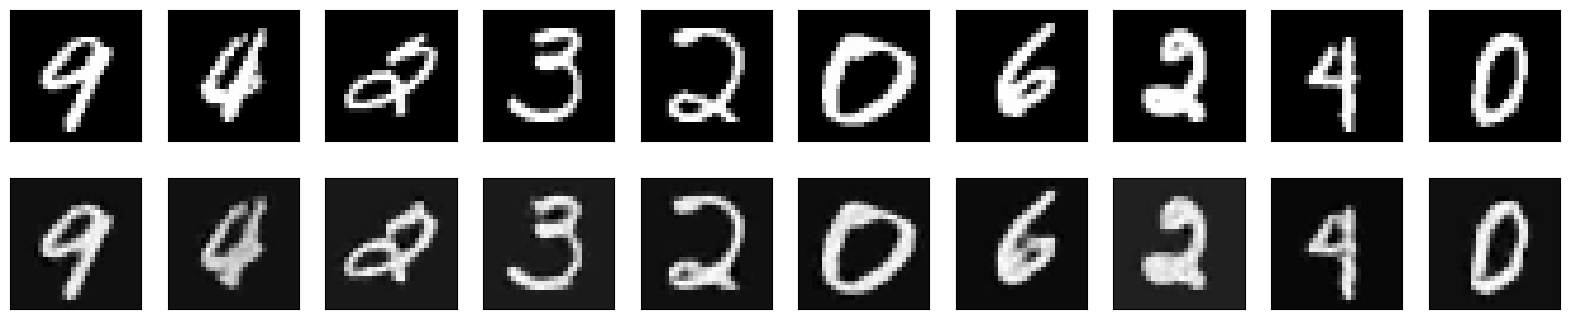

In [7]:
reconstructions_test = trained_model.predict(x_test)

display_diff(x_test, reconstructions_test['recon'])